In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

ModuleNotFoundError: No module named 'cv2'

In [2]:
IMAGE_SIZE = 384
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"


images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))
masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))

NUM_TRAIN_IMAGES = int(len(images) * 0.8)

train_images = images[:NUM_TRAIN_IMAGES]
train_masks = masks[:NUM_TRAIN_IMAGES]
val_images = images[NUM_TRAIN_IMAGES:]
val_masks = masks[NUM_TRAIN_IMAGES:]

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(2, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(2, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 224, 224, 1), dtype=tf.float32, name=None))>


In [3]:
data_augment = keras.Sequential([
    keras.layers.GaussianNoise(0.01, seed=42),
], name='Data_Augmentation')


BACKBONE = 'efficientnetb1'
preprocess_input = sm.get_preprocessing(BACKBONE)


model = sm.Unet(BACKBONE,
                classes=NUM_CLASSES,
                activation ='softmax',
                encoder_weights='imagenet',
               input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                             

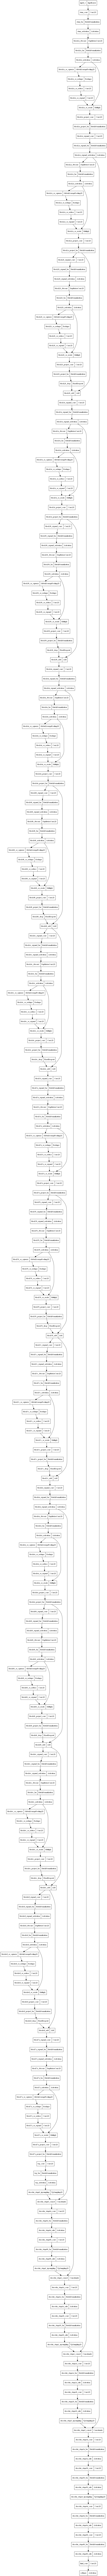

In [4]:
keras.utils.plot_model(model)

Epoch 1/2
11312/11312 [==============================] - 3751s 329ms/step - loss: 0.8102 - accuracy: 0.7423 - val_loss: 0.6838 - val_accuracy: 0.7796
Epoch 2/2
11312/11312 [==============================] - 3590s 317ms/step - loss: 0.6804 - accuracy: 0.7793 - val_loss: 0.6189 - val_accuracy: 0.7992


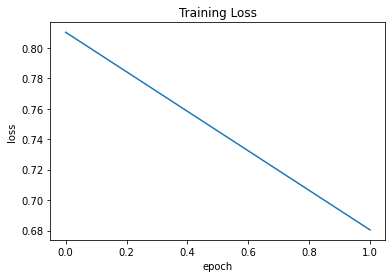

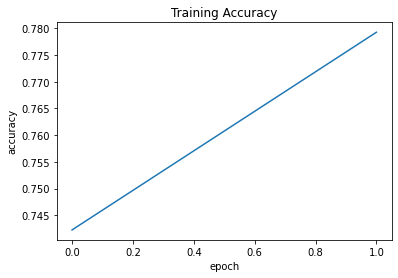

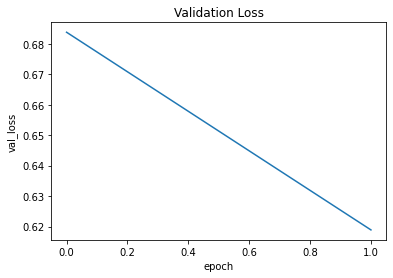

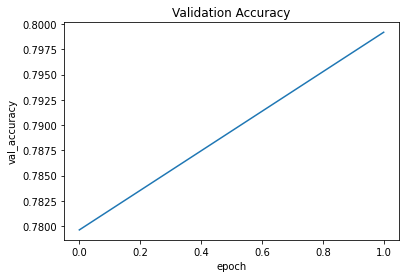

In [5]:
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    loss='SparseCategoricalCrossentropy',
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [6]:
model.save('ЕfficientNetb0_224_aug')

INFO:tensorflow:Assets written to: ЕfficientNetb0_224_aug\assets


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from imutils.video import VideoStream
from imutils.video import FPS
from matplotlib import pyplot as plt
print('---------------libs is ready----------------')

colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
print('---------------cmap is ready----------------')


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

print('---------------funcs is ready---------------')

IMAGE_SIZE = 448
print('---------------loading model----------------')
model = tf.keras.models.load_model(
    'efficientnetb1_384_lrd', compile=False)

print('---------------model is ready---------------')


# vs = VideoStream(src=0).start()
# fps = FPS().start()
cam = cv2.VideoCapture(0)

while True:
    ret, image = cam.read()
#     image = vs.read()
    cv2.imshow('camera', image)
#     image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))/127.5 - 1 + 0/255

    prediction = infer(model, img)
    mask = decode_segmentation_masks(prediction, colormap, 20)
    mask = cv2.resize(mask, (640, 480))
    mask_show = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    cv2.imshow('segmentation mask', mask_show)
    
    overlay = get_overlay(image, mask_show)
    cv2.imshow('image + mask', overlay)
    
    if cv2.waitKey(10) == 27:
        break

cv2.destroyAllWindows()

---------------libs is ready----------------
---------------cmap is ready----------------
---------------funcs is ready---------------
---------------loading model----------------
---------------model is ready---------------


KeyboardInterrupt: 